## SF crime data analysis and modeling

### In this notebook, you can learn how to use Spark SQL for big data analysis on SF crime data. (https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry). 
The first part of Homework is OLAP for scrime data analysis (80 credits).  
The second part is unsupervised learning for spatial data analysis (20 credits). 选做  
The option part is the time series data analysis (50 credits).  选座
**Note**: you can download the small data (one month e.g. 2018-10) for debug, then download the data from 2013 to 2018 for testing and analysising. 

### How to submit the report for grading ? 
1. Publish your notebook and send your notebook link to mike@laioffer.com. 
2. Your report have to contain your data analysis insights.  
3. write a ppt to present your work （选作）

### Bonus 
1. choose different city (加10分)
2. choose different analysis question （加10分）
3. include other data together like house price, weather, news (加20分)

### Deadline 
Two weeks from the homework release date

### cluster 创建
创建cluster 的时候选择python 3  

### 画图
1. 使用Databricks 自带的画图就好了，不要求使用其他的工具
2. 如果使用其他的包，请使用display 

### Time series 
不讲，个人随意

### others
个人需要发挥主观能动性

In [0]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import warnings

import os
os.environ["PYSPARK_PYTHON"] = "python3"


In [0]:
# 从SF gov 官网读取下载数据
# 不要反复执行，大家执行一次就好了啊
# 第二次记得comment 掉
# import urllib.request
# urllib.request.urlretrieve("https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD", "/tmp/myxxxx.csv")
# dbutils.fs.mv("file:/tmp/myxxxx.csv", "dbfs:/laioffer/spark_hw1/data/sf_03_18.csv")
# display(dbutils.fs.ls("dbfs:/laioffer/spark_hw1/data/"))
## 或者自己下载
# https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD


path,name,size
dbfs:/laioffer/spark_hw1/data/sf_03_18.csv,sf_03_18.csv,550945238


In [0]:
data_path = "dbfs:/laioffer/spark_hw1/data/sf_03_18.csv"
# use this file name later

### Solove  big data issues via Spark
approach 1: use RDD (not recommend)  
approach 2: use Dataframe, register the RDD to a dataframe (recommend for DE)  
approach 3: use SQL (recomend for data analysis or DS， 基础比较差的同学)  
***note***: you only need to choose one of approaches as introduced above

In [0]:

from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df_opt1 = spark.read.format("csv").option("header", "true").load(data_path)
display(df_opt1)
df_opt1.createOrReplaceTempView("sf_crime")

## helper function to transform the date, choose your way to do it. 
## 老师我真的是操心了。。。 
# refer: https://jaceklaskowski.gitbooks.io/mastering-spark-sql/spark-sql-functions-datetime.html
# 方法1 使用系统自带udf
# from pyspark.sql.functions import to_date, to_timestamp, hour
# df_opt1 = df_opt1.withColumn('Date', to_date(df_opt1.OccurredOn, "MM/dd/yy"))
# df_opt1 = df_opt1.withColumn('Time', to_timestamp(df_opt1.OccurredOn, "MM/dd/yy HH:mm"))
# df_opt1 = df_opt1.withColumn('Hour', hour(df_opt1['Time']))
# df_opt1 = df_opt1.withColumn("DayOfWeek", date_format(df_opt1.Date, "EEEE"))

## 方法2 手工写udf 
#from pyspark.sql.functions import col, udf
#from pyspark.sql.functions import expr
#from pyspark.sql.functions import from_unixtime

#date_func =  udf (lambda x: datetime.strptime(x, '%m/%d/%Y'), DateType())
#month_func = udf (lambda x: datetime.strptime(x, '%m/%d/%Y').strftime('%Y/%m'), StringType())

#df = df_opt1.withColumn('month_year', month_func(col('Date')))\
#           .withColumn('Date_time', date_func(col('Date')))

## 方法3 手工在sql 里面
# select Date, substring(Date,7) as Year, substring(Date,1,2) as Month from sf_crime


## 方法4: 使用系统自带
# from pyspark.sql.functions import *
# df_update = df_opt1.withColumn("Date", to_date(col("Date"), "MM/dd/yyyy")) ##change datetype from string to date
# df_update.createOrReplaceTempView("sf_crime")
# crimeYearMonth = spark.sql("SELECT Year(Date) AS Year, Month(Date) AS Month, FROM sf_crime")

PdId,IncidntNum,Incident Code,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,location,SF Find Neighborhoods 2 2,Current Police Districts 2 2,Current Supervisor Districts 2 2,Analysis Neighborhoods 2 2,DELETE - Fire Prevention Districts 2 2,DELETE - Police Districts 2 2,DELETE - Supervisor Districts 2 2,DELETE - Zip Codes 2 2,DELETE - Neighborhoods 2 2,DELETE - 2017 Fix It Zones 2 2,Civic Center Harm Reduction Project Boundary 2 2,Fix It Zones as of 2017-11-06 2 2,DELETE - HSOC Zones 2 2,Fix It Zones as of 2018-02-07 2 2,"CBD, BID and GBD Boundaries as of 2017 2 2","Areas of Vulnerability, 2016 2 2",Central Market/Tenderloin Boundary 2 2,Central Market/Tenderloin Boundary Polygon - Updated 2 2,HSOC Zones as of 2018-06-05 2 2,OWED Public Spaces 2 2,Neighborhoods 2
3114751606302,031147516,06302,LARCENY/THEFT,PETTY THEFT FROM A BUILDING,Sunday,09/28/2003,10:00,SOUTHERN,NONE,1ST ST / BRANNAN ST,-120.5,90,POINT (-120.50000000000001 90),null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
5069701104134,050697011,04134,ASSAULT,BATTERY,Wednesday,06/22/2005,12:20,NORTHERN,NONE,1200 Block of EDDY ST,-122.428223303176,37.7818959488603,POINT (-122.42822330317601 37.7818959488603),97,4,11,39,7,9,11,29490,41,null,null,null,null,null,null,2,null,null,null,null,97
6074729204104,060747292,04104,ASSAULT,ASSAULT,Saturday,07/15/2006,00:55,CENTRAL,NONE,1600 Block of POWELL ST,-122.410672425337,37.799788690123,POINT (-122.41067242533701 37.799788690123),106,6,3,6,3,1,10,308,4,null,null,null,null,null,null,2,null,null,null,null,106
7103536315201,071035363,15201,ASSAULT,STALKING,Tuesday,09/25/2007,00:01,TARAVAL,NONE,400 Block of ULLOA ST,-122.458226300605,37.7413616001449,POINT (-122.458226300605 37.7413616001449),49,10,8,41,1,8,4,59,40,null,null,null,null,null,null,1,null,null,null,null,49
11082415274000,110824152,74000,MISSING PERSON,MISSING ADULT,Saturday,09/24/2011,11:00,TARAVAL,LOCATED,3200 Block of SAN JOSE AV,-122.459172646607,37.7082001648459,POINT (-122.459172646607 37.7082001648459),null,null,null,null,null,null,null,28588,null,null,null,null,null,null,null,null,null,null,null,null,null
4037801104134,040378011,04134,ASSAULT,BATTERY,Friday,12/12/2003,12:00,SOUTHERN,NONE,500 Block of I-80,-122.386667033903,37.7898821569191,POINT (-122.38666703390301 37.7898821569191),null,null,null,null,null,null,null,28856,null,null,null,null,null,null,null,null,null,null,null,null,null
4147669007025,041476690,07025,VEHICLE THEFT,STOLEN TRUCK,Thursday,12/30/2004,19:00,BAYVIEW,NONE,100 Block of KAREN CT,-122.407531316146,37.723291086507,POINT (-122.40753131614602 37.723291086507),91,2,2,25,10,3,7,309,28,null,null,null,null,null,null,1,null,null,null,null,91
16010127305073,160101273,05073,BURGLARY,"BURGLARY, UNLAWFUL ENTRY",Wednesday,02/03/2016,20:30,MISSION,"ARREST, BOOKED",2300 Block of 16TH ST,-122.40952991327822,37.76571843952822,POINT (-122.40952991327822 37.76571843952822),53,3,9,20,8,4,8,28853,19,null,null,null,3,null,null,2,null,null,3,null,53
17004924306243,170049243,06243,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,Wednesday,01/18/2017,18:20,TARAVAL,NONE,NORIEGA ST / SUNSET BL,-122.49522504431104,37.75341185338174,POINT (-122.49522504431104 37.75341185338174),39,10,7,35,1,8,3,56,35,null,null,null,null,null,null,1,null,null,null,null,39
16065828006244,160658280,06244,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,08/14/2016,21:00,TARAVAL,NONE,3200 Block of 20TH AV,-122.47564746078615,37.72852806274646,POINT (-122.47564746078615 37.72852806274647),41,10,8,16,1,8,4,64,14,null,null,null,null,null,null,2,null,null,null,null,41


#### Q1 question (OLAP): 
#####Write a Spark program that counts the number of crimes for different category.

Below are some example codes to demonstrate the way to use Spark RDD, DF, and SQL to work with big data. You can follow this example to finish other questions.

In [0]:
q1_result = df_opt1.groupBy('category').count().orderBy('count', ascending=False)
display(q1_result)

category,count
LARCENY/THEFT,477975
OTHER OFFENSES,301874
NON-CRIMINAL,236928
ASSAULT,167042
VEHICLE THEFT,126228
DRUG/NARCOTIC,117821
VANDALISM,114718
WARRANTS,99821
BURGLARY,91067
SUSPICIOUS OCC,79087


In [0]:
#Spark SQL based
crimeCategory = spark.sql("SELECT  category, COUNT(*) AS Count FROM sf_crime GROUP BY category ORDER BY Count DESC")
display(crimeCategory)

category,Count
LARCENY/THEFT,477975
OTHER OFFENSES,301874
NON-CRIMINAL,236928
ASSAULT,167042
VEHICLE THEFT,126228
DRUG/NARCOTIC,117821
VANDALISM,114718
WARRANTS,99821
BURGLARY,91067
SUSPICIOUS OCC,79087


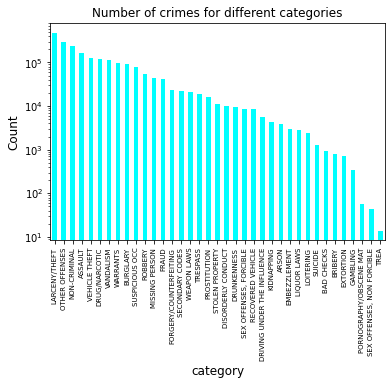

In [0]:
# important hints: 
## first step: spark df or sql to compute the statisitc result 
## second step: export your result to a pandas dataframe. 

crimes_pd_df = crimeCategory.toPandas()

# Spark does not support this function, please refer https://matplotlib.org/ for visuliation. You need to use display to show the figure in the databricks community. 

#display(crimes_pd_df)

plt.figure()
ax = crimes_pd_df.plot(kind='bar', x='category', y='Count', logy=True, color='cyan', legend=False, align='center')
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('category', fontsize=12)
plt.xticks(fontsize=7, rotation=90)
plt.title('Number of crimes for different categories')
display()

#### Q2 question (OLAP)
Counts the number of crimes for different district, and visualize your results

In [0]:
# Spark dataframe based
district_result = df_opt1.groupBy('PdDistrict').count().orderBy('count', ascending=False)
display(district_result)

PdDistrict,count
SOUTHERN,390692
MISSION,288985
NORTHERN,266435
CENTRAL,221923
BAYVIEW,205480
TENDERLOIN,186954
INGLESIDE,181092
TARAVAL,155461
PARK,119698
RICHMOND,112804


In [0]:
#Spark SQL based
crimeDistrict = spark.sql("SELECT PdDistrict AS district, COUNT(*) AS count FROM sf_crime GROUP BY PdDistrict ORDER BY Count DESC")
display(crimeDistrict)

district,count
SOUTHERN,390692
MISSION,288985
NORTHERN,266435
CENTRAL,221923
BAYVIEW,205480
TENDERLOIN,186954
INGLESIDE,181092
TARAVAL,155461
PARK,119698
RICHMOND,112804


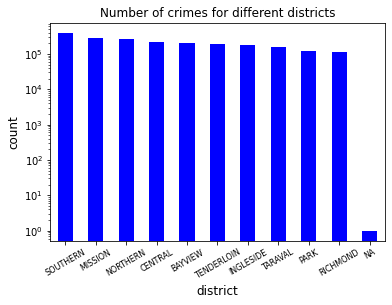

In [0]:
# Data Visulization 
crimes_district_pd_df = crimeDistrict.toPandas()
#display(crimes_district_pd_df)

ax = crimes_district_pd_df.plot(kind ='bar', x='district', y='count', logy=True, color='blue', legend=False, align='center')
ax.set_ylabel('count', fontsize=12)
ax.set_xlabel('district', fontsize=12)
plt.xticks(fontsize=8, rotation=30)
plt.title('Number of crimes for different districts')
display()

#### Q3 question (OLAP)
Count the number of crimes each "Sunday" at "SF downtown".   
hint 1: SF downtown is defiend  via the range of spatial location. For example, you can use a rectangle to define the SF downtown, or you can define a cicle with center as well. Thus, you need to write your own UDF function to filter data which are located inside certain spatial range. You can follow the example here: https://changhsinlee.com/pyspark-udf/

hint 2: SF downtown 物理范围可以是 rectangle a < x < b  and c < y < d. thus, San Francisco Latitude and longitude coordinates are: 37.773972, -122.431297. X and Y represents each. So we assume SF downtown spacial range: X (-122.4213,-122.4313), Y(37.7540,37.7740). 也可以是中心一个圈，距离小于多少算做downtown

In [0]:
df_opt2 = df_opt1[['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location']]
display(df_opt2)
df_opt2.createOrReplaceTempView("sf_crime")

IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location
031147516,LARCENY/THEFT,PETTY THEFT FROM A BUILDING,Sunday,09/28/2003,10:00,SOUTHERN,NONE,1ST ST / BRANNAN ST,-120.5,90,POINT (-120.50000000000001 90)
050697011,ASSAULT,BATTERY,Wednesday,06/22/2005,12:20,NORTHERN,NONE,1200 Block of EDDY ST,-122.428223303176,37.7818959488603,POINT (-122.42822330317601 37.7818959488603)
060747292,ASSAULT,ASSAULT,Saturday,07/15/2006,00:55,CENTRAL,NONE,1600 Block of POWELL ST,-122.410672425337,37.799788690123,POINT (-122.41067242533701 37.799788690123)
071035363,ASSAULT,STALKING,Tuesday,09/25/2007,00:01,TARAVAL,NONE,400 Block of ULLOA ST,-122.458226300605,37.7413616001449,POINT (-122.458226300605 37.7413616001449)
110824152,MISSING PERSON,MISSING ADULT,Saturday,09/24/2011,11:00,TARAVAL,LOCATED,3200 Block of SAN JOSE AV,-122.459172646607,37.7082001648459,POINT (-122.459172646607 37.7082001648459)
040378011,ASSAULT,BATTERY,Friday,12/12/2003,12:00,SOUTHERN,NONE,500 Block of I-80,-122.386667033903,37.7898821569191,POINT (-122.38666703390301 37.7898821569191)
041476690,VEHICLE THEFT,STOLEN TRUCK,Thursday,12/30/2004,19:00,BAYVIEW,NONE,100 Block of KAREN CT,-122.407531316146,37.723291086507,POINT (-122.40753131614602 37.723291086507)
160101273,BURGLARY,"BURGLARY, UNLAWFUL ENTRY",Wednesday,02/03/2016,20:30,MISSION,"ARREST, BOOKED",2300 Block of 16TH ST,-122.40952991327822,37.76571843952822,POINT (-122.40952991327822 37.76571843952822)
170049243,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,Wednesday,01/18/2017,18:20,TARAVAL,NONE,NORIEGA ST / SUNSET BL,-122.49522504431104,37.75341185338174,POINT (-122.49522504431104 37.75341185338174)
160658280,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,08/14/2016,21:00,TARAVAL,NONE,3200 Block of 20TH AV,-122.47564746078615,37.72852806274646,POINT (-122.47564746078615 37.72852806274647)


In [0]:
from pyspark.sql.functions import to_date, month, year
# add new columns to convert Date to date format
df_new = df_opt2.withColumn("IncidentDate", to_date(df_opt2.Date, "MM/dd/yyyy")) 
# extract month and year from incident date
df_new = df_new.withColumn('Month', month(df_new['IncidentDate']))
df_new = df_new.withColumn('Year', year(df_new['IncidentDate']))
display(df_new.take(5))
df_new.createOrReplaceTempView("sf_crime")

IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,IncidentDate,Month,Year
031147516,LARCENY/THEFT,PETTY THEFT FROM A BUILDING,Sunday,09/28/2003,10:00,SOUTHERN,NONE,1ST ST / BRANNAN ST,-120.5,90,POINT (-120.50000000000001 90),2003-09-28,9,2003
050697011,ASSAULT,BATTERY,Wednesday,06/22/2005,12:20,NORTHERN,NONE,1200 Block of EDDY ST,-122.428223303176,37.7818959488603,POINT (-122.42822330317601 37.7818959488603),2005-06-22,6,2005
060747292,ASSAULT,ASSAULT,Saturday,07/15/2006,00:55,CENTRAL,NONE,1600 Block of POWELL ST,-122.410672425337,37.799788690123,POINT (-122.41067242533701 37.799788690123),2006-07-15,7,2006
071035363,ASSAULT,STALKING,Tuesday,09/25/2007,00:01,TARAVAL,NONE,400 Block of ULLOA ST,-122.458226300605,37.7413616001449,POINT (-122.458226300605 37.7413616001449),2007-09-25,9,2007
110824152,MISSING PERSON,MISSING ADULT,Saturday,09/24/2011,11:00,TARAVAL,LOCATED,3200 Block of SAN JOSE AV,-122.459172646607,37.7082001648459,POINT (-122.459172646607 37.7082001648459),2011-09-24,9,2011


In [0]:
# Count the number of crimes each "Sunday" at "SF downtown" 
# Spark dataframe based
sf_downtown = (df_new.X > -122.4313) & (df_new.X < -122.4213) & (df_new.Y < 37.7740) & (df_new.Y > 37.7540 )
crimePosition = df_new.filter((df_new.DayOfWeek == "Sunday") & (sf_downtown)).groupby('IncidentDate','DayOfWeek').count().orderBy('IncidentDate')
display(crimePosition)

IncidentDate,DayOfWeek,count
2003-01-05,Sunday,13
2003-01-12,Sunday,20
2003-01-19,Sunday,17
2003-01-26,Sunday,13
2003-02-02,Sunday,14
2003-02-09,Sunday,22
2003-02-16,Sunday,12
2003-02-23,Sunday,14
2003-03-02,Sunday,16
2003-03-09,Sunday,8


In [0]:
# Spark SQL based
spark_sql_q3 = spark.sql("""
                         SELECT IncidentDate, DayOfWeek, COUNT(*) AS Count FROM sf_crime 
                         WHERE DayOfWeek = 'Sunday' AND X > -122.4313 AND X < -122.4213 AND Y > 37.7540 AND Y < 37.7740
                         GROUP BY IncidentDate, DayOfWeek 
                         ORDER BY IncidentDate
                         """)
display(spark_sql_q3)

IncidentDate,DayOfWeek,Count
2003-01-05,Sunday,13
2003-01-12,Sunday,20
2003-01-19,Sunday,17
2003-01-26,Sunday,13
2003-02-02,Sunday,14
2003-02-09,Sunday,22
2003-02-16,Sunday,12
2003-02-23,Sunday,14
2003-03-02,Sunday,16
2003-03-09,Sunday,8


#### Q4 question (OLAP)
Analysis the number of crime in each month of 2015, 2016, 2017, 2018. Then, give your insights for the output results. What is the business impact for your result?

In [0]:
years = [2015, 2016, 2017, 2018]
df_years = df_new[df_new.Year.isin(years)]
display(df_years.take(5))

IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,IncidentDate,Month,Year
160101273,BURGLARY,"BURGLARY, UNLAWFUL ENTRY",Wednesday,02/03/2016,20:30,MISSION,"ARREST, BOOKED",2300 Block of 16TH ST,-122.40952991327822,37.76571843952822,POINT (-122.40952991327822 37.76571843952822),2016-02-03,2,2016
170049243,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,Wednesday,01/18/2017,18:20,TARAVAL,NONE,NORIEGA ST / SUNSET BL,-122.49522504431104,37.75341185338174,POINT (-122.49522504431104 37.75341185338174),2017-01-18,1,2017
160658280,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,08/14/2016,21:00,TARAVAL,NONE,3200 Block of 20TH AV,-122.47564746078615,37.72852806274646,POINT (-122.47564746078615 37.72852806274647),2016-08-14,8,2016
180322603,DRUG/NARCOTIC,POSSESSION OF HEROIN,Tuesday,05/01/2018,13:27,SOUTHERN,"ARREST, BOOKED",600 Block of STEVENSON ST,-122.41265189435406,37.77951316688882,POINT (-122.41265189435406 37.77951316688882),2018-05-01,5,2018
176125180,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,05/16/2017,13:00,RICHMOND,NONE,500 Block of JOHNFKENNEDY DR,-122.46620466789287,37.772540539159316,POINT (-122.46620466789287 37.772540539159316),2017-05-16,5,2017


In [0]:
# Spark dataframe based
spark_df_q4 = df_years.groupby(['Year', 'Month']).count().orderBy('Year','Month')
display(spark_df_q4)

Year,Month,count
2015,1,13181
2015,2,11882
2015,3,13463
2015,4,12526
2015,5,13318
2015,6,12853
2015,7,12949
2015,8,13317
2015,9,12476
2015,10,12697


In [0]:
# Spark SQL based
df_opt2.createOrReplaceTempView('sf_crime')

q4_result = spark.sql("""
                      SELECT SUBSTRING(Date,1,2) AS Month, SUBSTRING(Date,7,4) AS Year, COUNT(*) AS Count
                      FROM sf_crime
                      GROUP BY Year, Month
                      HAVING Year in (2015, 2016, 2017, 2018) 
                      ORDER BY Year, Month
                      """)
display(q4_result)

Month,Year,Count
01,2015,13181
02,2015,11882
03,2015,13463
04,2015,12526
05,2015,13318
06,2015,12853
07,2015,12949
08,2015,13317
09,2015,12476
10,2015,12697


#### Q4 Insights
* From the above figure, we can see that the crime rate from 2015 to 2017 is very high and there has been a downward trend in 2018, especially in May.
* Potential Business Impact: Starting from 2018, the SF Police Department has been put more effor on improving public security.

#### Q5 question (OLAP)
Analysis the number of crime w.r.t the hour in certian day like 2015/12/15, 2016/12/15, 2017/12/15. Then, give your travel suggestion to visit SF.

In [0]:
from pyspark.sql.functions import to_timestamp, hour
# add new columns to convert Time to hour format
df_new1 = df_new.withColumn('IncidentTime', to_timestamp(df_new['Time'], 'HH:mm'))
# extract hour from incident time
df_new1 = df_new1.withColumn('Hour', hour(df_new1['IncidentTime']))
display(df_new1.take(5))

IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,IncidentDate,Month,Year,IncidentTime,Hour
031147516,LARCENY/THEFT,PETTY THEFT FROM A BUILDING,Sunday,09/28/2003,10:00,SOUTHERN,NONE,1ST ST / BRANNAN ST,-120.5,90,POINT (-120.50000000000001 90),2003-09-28,9,2003,1970-01-01T10:00:00.000+0000,10
050697011,ASSAULT,BATTERY,Wednesday,06/22/2005,12:20,NORTHERN,NONE,1200 Block of EDDY ST,-122.428223303176,37.7818959488603,POINT (-122.42822330317601 37.7818959488603),2005-06-22,6,2005,1970-01-01T12:20:00.000+0000,12
060747292,ASSAULT,ASSAULT,Saturday,07/15/2006,00:55,CENTRAL,NONE,1600 Block of POWELL ST,-122.410672425337,37.799788690123,POINT (-122.41067242533701 37.799788690123),2006-07-15,7,2006,1970-01-01T00:55:00.000+0000,0
071035363,ASSAULT,STALKING,Tuesday,09/25/2007,00:01,TARAVAL,NONE,400 Block of ULLOA ST,-122.458226300605,37.7413616001449,POINT (-122.458226300605 37.7413616001449),2007-09-25,9,2007,1970-01-01T00:01:00.000+0000,0
110824152,MISSING PERSON,MISSING ADULT,Saturday,09/24/2011,11:00,TARAVAL,LOCATED,3200 Block of SAN JOSE AV,-122.459172646607,37.7082001648459,POINT (-122.459172646607 37.7082001648459),2011-09-24,9,2011,1970-01-01T11:00:00.000+0000,11


In [0]:
# Spark dataframe based
dates = ['12/15/2015','12/15/2016','12/15/2017']
df_days = df_new1[df_new1.Date.isin(dates)]

spark_df_q5 = df_days.groupby('Hour','Date').count().orderBy('Date','Hour')
display(spark_df_q5)

Hour,Date,count
0,12/15/2015,15
1,12/15/2015,6
2,12/15/2015,5
3,12/15/2015,4
4,12/15/2015,10
5,12/15/2015,3
6,12/15/2015,4
7,12/15/2015,8
8,12/15/2015,12
9,12/15/2015,10


In [0]:
# Spark SQL Based
q5_result = spark.sql("""
                      SELECT Date,
                             SUBSTRING(Time,1,2) AS Hour, 
                             SUBSTRING(Date,7) AS Year, 
                             COUNT(*) AS Count
                      FROM sf_crime
                      WHERE SUBSTRING(Date,1,5) = '12/15' 
                      GROUP BY Hour, Date 
                      Having Year in (2015, 2016, 2017) 
                      ORDER BY Date, Hour
                      """)

display(q5_result)

Date,Hour,Year,Count
12/15/2015,00,2015,15
12/15/2015,01,2015,6
12/15/2015,02,2015,5
12/15/2015,03,2015,4
12/15/2015,04,2015,10
12/15/2015,05,2015,3
12/15/2015,06,2015,4
12/15/2015,07,2015,8
12/15/2015,08,2015,12
12/15/2015,09,2015,10


#### Q5 Travel Suggestion (OLAP)
By looking the output results, crime would mostly to happen in lunch time (12:00pm) and dinner time (18:00pm). So remind traveller not to relax their vigilance while eating and resting.

#### Q6 question (OLAP)
(1) Step1: Find out the top-3 danger disrict  
(2) Step2: find out the crime event w.r.t category and time (hour) from the result of step 1  
(3) give your advice to distribute the police based on your analysis results.

In [0]:
# Spark dateframe based
spark_df_q6 = df_new.groupBy('PdDistrict').count().orderBy('count', ascending=False)
display(spark_df_q6)

PdDistrict,count
SOUTHERN,390692
MISSION,288985
NORTHERN,266435
CENTRAL,221923
BAYVIEW,205480
TENDERLOIN,186954
INGLESIDE,181092
TARAVAL,155461
PARK,119698
RICHMOND,112804


In [0]:
top3_danger_district = df_new.groupBy('PdDistrict').count().orderBy('count', ascending=False).head(3)
display(top3_danger_district)

PdDistrict,count
SOUTHERN,390692
MISSION,288985
NORTHERN,266435


In [0]:
# Spark SQL based
q6_result = spark.sql("""
                      SELECT PdDistrict, COUNT(*) as Count
                      FROM sf_crime
                      GROUP BY 1
                      ORDER BY 2 DESC
                      LIMIT 3
                      """)

q6_result.createOrReplaceTempView("q6_result")
display(q6_result)

PdDistrict,Count
SOUTHERN,390692
MISSION,288985
NORTHERN,266435


In [0]:
# Spark dateframe based
spark_df_q6_s2 = df_new1.filter(df_new1.PdDistrict.isin('SOUTHERN', 'MISSION', 'NORTHERN')).groupby('Category','Hour').count().orderBy('Category','Hour')
display(spark_df_q6_s2)

Category,Hour,count
ARSON,0,84
ARSON,1,77
ARSON,2,84
ARSON,3,95
ARSON,4,74
ARSON,5,60
ARSON,6,50
ARSON,7,28
ARSON,8,34
ARSON,9,28


In [0]:
# Spark SQL based
top3_danger_district_s2 = spark.sql("""
                                    SELECT sf_crime.PdDistrict, sf_crime.category, SUBSTRING(sf_crime.Time, 1,2) AS Hour
                                    FROM sf_crime
                                    INNER JOIN q6_result ON sf_crime.PdDistrict = q6_result.PdDistrict
                                    """)

top3_danger_district_s2.createOrReplaceTempView("top3_danger_district_s2")


q6_result_s2 = spark.sql("""
                         SELECT category, Hour, COUNT(*) AS Crime_Number
                         FROM top3_danger_district_s2
                         GROUP BY 1, 2
                         ORDER BY 1, 2
                         """)
display(q6_result_s2)

category,Hour,Crime_Number
ARSON,00,84
ARSON,01,77
ARSON,02,84
ARSON,03,95
ARSON,04,74
ARSON,05,60
ARSON,06,50
ARSON,07,28
ARSON,08,34
ARSON,09,28


#### Q6 Advice based on the analysis result
* The top three most dangerours districts are SOUTHERN, MISSION, NORTHERN.
* By looking through the houly crimes, SOUTHERN has more over crimes than the other two distict, which needs to have more police power covered.
* The number of crimes are lowest around 5AM, and the high incidence of crime rate is around 12pm and 18pm, espcially pay attention to theft. So I recommend the police force shoud be out during that periods.

#### Q7 question (OLAP)
For different category of crime, find the percentage of resolution. Based on the output, give your hints to adjust the policy.

In [0]:
%sql select distinct(resolution) as resolve from sf_crime

resolve
EXCEPTIONAL CLEARANCE
"ARREST, BOOKED"
PROSECUTED FOR LESSER OFFENSE
LOCATED
UNFOUNDED
DISTRICT ATTORNEY REFUSES TO PROSECUTE
PSYCHOPATHIC CASE
COMPLAINANT REFUSES TO PROSECUTE
"ARREST, CITED"
PROSECUTED BY OUTSIDE AGENCY


In [0]:
#display(df_opt2)
import pyspark.sql.functions as f
from pyspark.sql.window import Window
resolution_func = udf(lambda x: x!= 'NONE')
spark_df_q7 = df_opt2.withColumn('isResolution', resolution_func(f.col('Resolution')))
spark_df_q7 = spark_df_q7.groupBy('category', 'isResolution').count().orderBy('category')
spark_df_q7 = spark_df_q7.withColumn('total', f.sum('count').over(Window.partitionBy('category')))\
                         .withColumn('percent', f.col('count')/f.col('total'))\
                         .filter(spark_df_q7.isResolution == True)\
                         .orderBy('percent', ascending = False)

display(spark_df_q7)

category,isResolution,count,total,percent
PROSTITUTION,true,15651,16501,0.9484879704260348
WARRANTS,true,94339,99821,0.9450816962362629
DRIVING UNDER THE INFLUENCE,true,5335,5652,0.9439136588818118
DRUG/NARCOTIC,true,107565,117821,0.912952699433887
LIQUOR LAWS,true,2527,2840,0.8897887323943662
LOITERING,true,2103,2402,0.8755203996669442
STOLEN PROPERTY,true,10011,11450,0.8743231441048035
DRUNKENNESS,true,8035,9760,0.8232581967213115
OTHER OFFENSES,true,215059,301874,0.7124131260062145
WEAPON LAWS,true,14934,21004,0.711007427156732


In [0]:
display(spark_df_q7)

category,isResolution,count,total,percent
PROSTITUTION,true,15651,16501,0.9484879704260348
WARRANTS,true,94339,99821,0.9450816962362629
DRIVING UNDER THE INFLUENCE,true,5335,5652,0.9439136588818118
DRUG/NARCOTIC,true,107565,117821,0.912952699433887
LIQUOR LAWS,true,2527,2840,0.8897887323943662
LOITERING,true,2103,2402,0.8755203996669442
STOLEN PROPERTY,true,10011,11450,0.8743231441048035
DRUNKENNESS,true,8035,9760,0.8232581967213115
OTHER OFFENSES,true,215059,301874,0.7124131260062145
WEAPON LAWS,true,14934,21004,0.711007427156732


#### Q7 Insights
* The top four categories of crimes resolved are PROSTITUTION, WARRANTS, DRIVING UNDER THE INFLUENCE and DRUG/NARCOTIC.
* The categories which less than 10% of crimes resolved are LARCENY/THEFT, VEHICLE THEFT and RECOVERED VEHICLE.
* Police should increse force to solve these theft-related crimes.

### Conclusion. 
Use four sentences to summary your work. Like what you have done, how to do it, what the techinical steps, what is your business impact. 
More details are appreciated. You can think about this a report for your manager. Then, you need to use this experience to prove that you have strong background on big  data analysis.  
Point 1:  what is your story ? and why you do this work ?   
Point 2:  how can you do it ?  keywords: Spark, Spark SQL, Dataframe, Data clean, Data visulization, Data size, clustering, OLAP,   
Point 3:  what do you learn from the data ?  keywords: crime, trend, advising, conclusion, runtime

### Final Summarization
For this exploratory data project, I am interested in looking and learning the crime trend in SF. In this notebook, I utilized Spark, Dataframe and Data visulization to help me understand the data and study the trends and potential problems. The analysis tells me that the most dangerous crime districts, trend of crime yearly basis, monthly basis and hourly basis. I also looked at the resolution rate of different categories of crimes to see how to handle it well over the time.

### Optional part: Clustering
You can apply Spark ML custering algorithm to cluster the spatial data, then visualize the clustering results. Do not do this until you understand Spark ML, we would like to cover this in the DS track.

### Optional part: Time series analysis
This part is not based on Spark, and only based on Pandas Time Series package.   
Note: I am not familiar with time series model, please refer the ARIMA model introduced by other teacher.   
process:  
1.visualize time series  
2.plot ACF and find optimal parameter  
3.Train ARIMA  
4.Prediction 

Refer:   
https://zhuanlan.zhihu.com/p/35282988  
https://zhuanlan.zhihu.com/p/35128342  
https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html  
https://www.howtoing.com/a-guide-to-time-series-forecasting-with-arima-in-python-3  
https://www.joinquant.com/post/9576?tag=algorithm  
https://blog.csdn.net/u012052268/article/details/79452244

#### How to implement a inner join/ left join/right join via Python? 选做哈

For example 

Array 1: [[1, "mike", "f"], [2, "jason", "f"], [3, "robin", "m"], ...] 

Array 2: [[1, "95051", "CS"], [2, "95001", "DS"], [6, "robin", "DE"], ...]